<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/NYC_Traffic_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Camera Stream Analysis
See the Roboflow blog post for this project!


**NOTE:** While everything produced in the blog post was done (and therefore is possible to do) in Google Colab, there are some limitations:

1.   The default `render_boxes` sink from Inference is not supported in Google Colab. (An alternative custom sink has been implemented in the Colab below)
2.   Inferences may take a considerable amount of time, especially on CPU Colabs
3.   You should not use Google Colab to run this for a long period of time. The Colab will timeout. (If you have Colab Pro, you are good for ~12 hrs)



In [ ]:
!pip install inference -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 995.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

# Basic

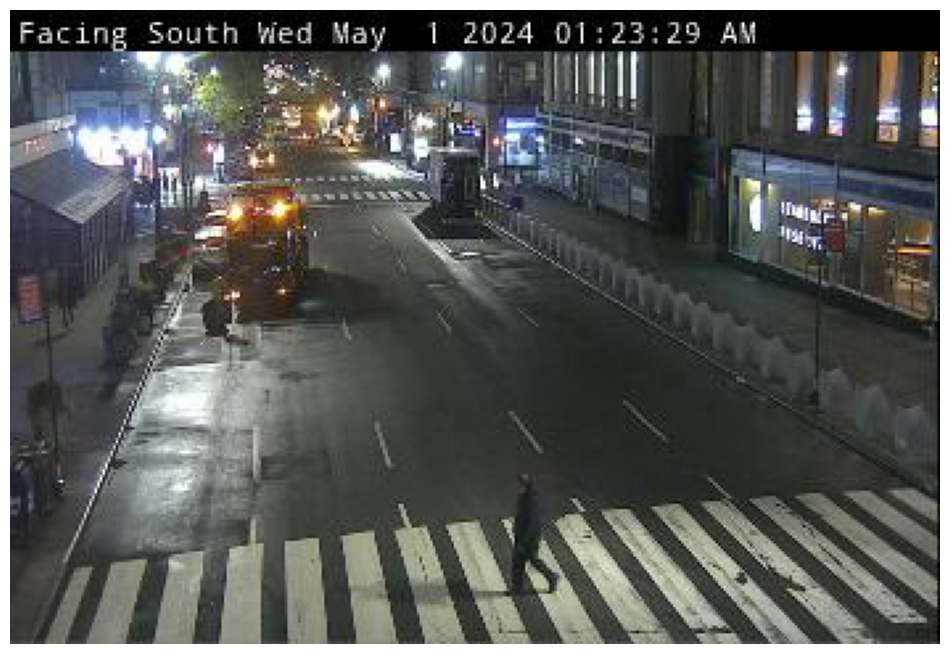

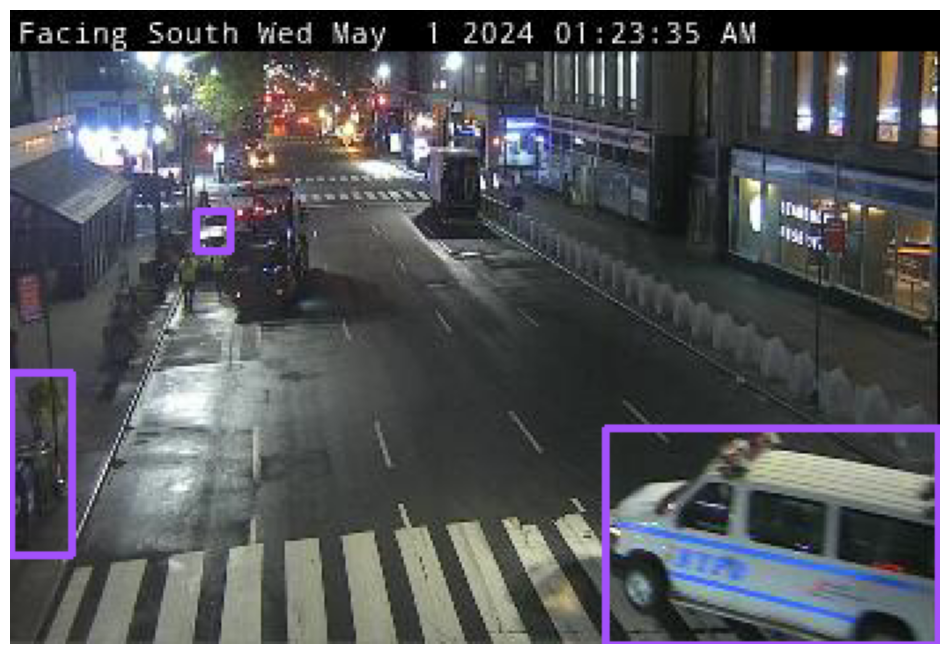

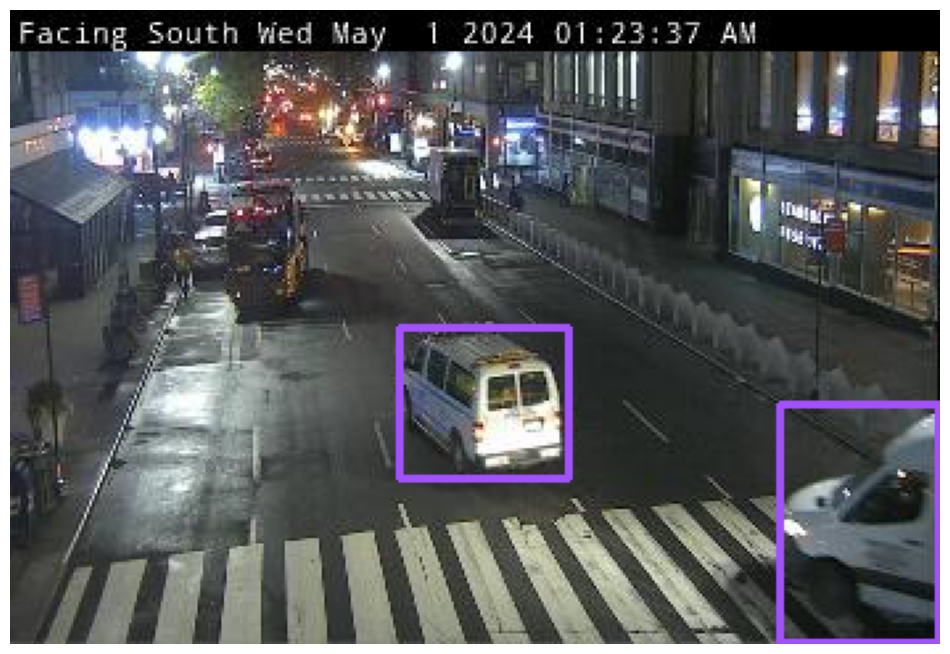

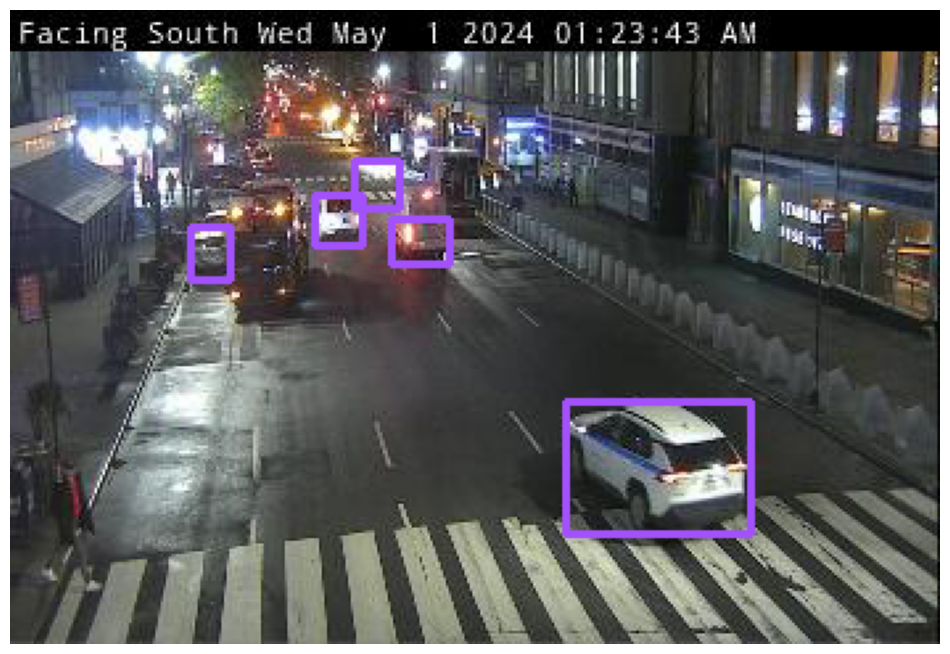

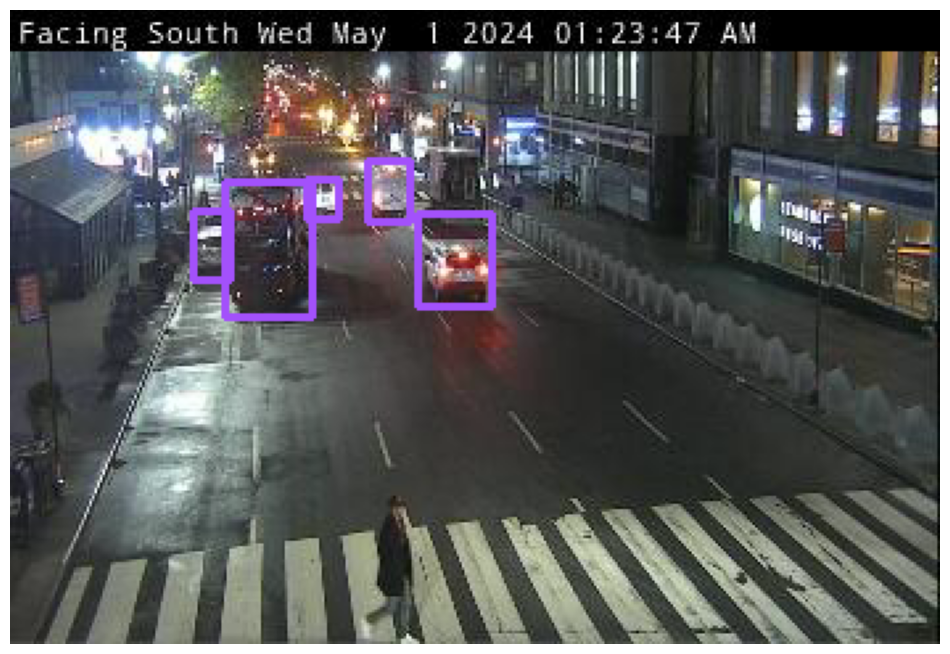

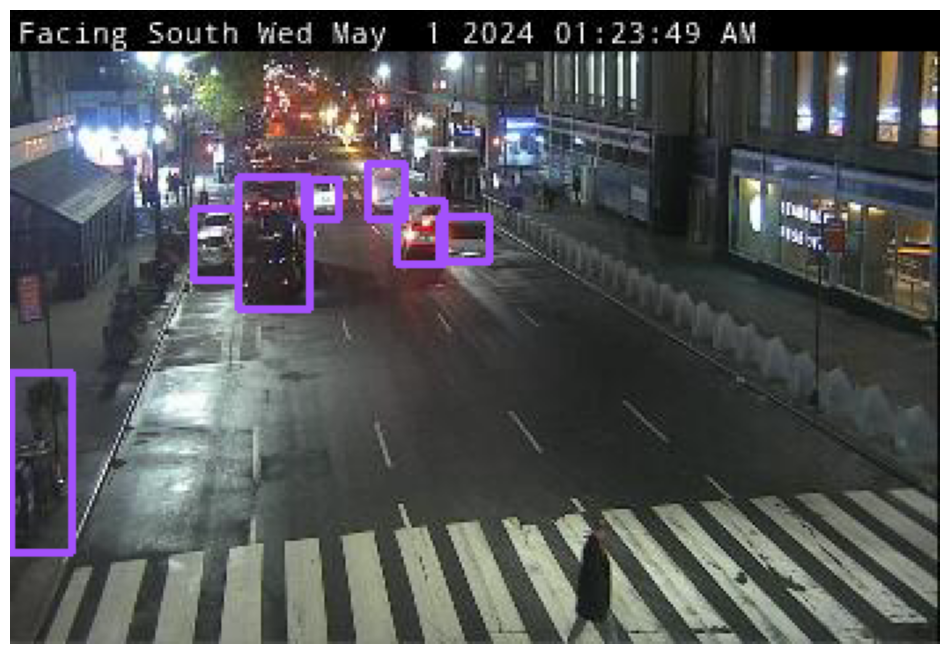

KeyboardInterrupt: 

In [ ]:
# Imports and Setup
import cv2
from inference import InferencePipeline
from inference.core.interfaces.stream.sinks import render_boxes
import supervision as sv

from google.colab import userdata
api_key = userdata.get('ROBOFLOW_API_KEY')

def on_prediction(predictions, video_frame):
  detections = sv.Detections.from_inference(predictions)
  annotated_frame = sv.BoundingBoxAnnotator().annotate(video_frame.image, detections)
  sv.plot_image(annotated_frame)

pipeline = InferencePipeline.init(
  model_id="vehicle-detection-3mmwj/1",
  max_fps=0.5,
  confidence=0.3,
  video_reference="https://webcams.nyctmc.org/api/cameras/3a3d7bc0-7f35-46ba-9cca-75fe83aac34d/image",
  on_prediction=on_prediction, # render_boxes uses cv2.imshow which does not work in Google Colab
  api_key=api_key
)

pipeline.start()
pipeline.join()

In [ ]:
# OUTPUTS A VIDEO

# Google Colab
from google.colab import auth, userdata
api_key = userdata.get('ROBOFLOW_API_KEY')

# VideoWriter Setup
import cv2
video_info = (352, 240, 24)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter("nyc_traffic_timelapse.mp4", fourcc, video_info[2], video_info[:2])

# Interrupt Handling
import signal
import sys

def signal_handler(sig, frame):
  writer.release()
  print("Keyboard Interrupt")
  sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)

from inference import InferencePipeline
from datetime import datetime
import pytz
import supervision as sv

def on_prediction(predictions, video_frame, writer):
  # Process Results
  detections = sv.Detections.from_inference(predictions)
  annotated_frame = sv.BoundingBoxAnnotator().annotate(video_frame.image, detections)

  # Add Frame To Timelapse
  writer.write(annotated_frame)


pipeline = InferencePipeline.init(
  model_id="vehicle-detection-3mmwj/1",
  max_fps=0.5,
  confidence=0.3,
  video_reference="https://webcams.nyctmc.org/api/cameras/053e8995-f8cb-4d02-a659-70ac7c7da5db/image",
  on_prediction=lambda predictions, video_frame: on_prediction(predictions, video_frame, writer),
  api_key=api_key
)

pipeline.start()
pipeline.join()

writer.release()

Keyboard Interrupt


SystemExit: 0

# Single Stream

In [ ]:
!pip install gspread -q

In [ ]:
# Google Colab
from google.colab import auth, userdata
api_key = userdata.get('ROBOFLOW_API_KEY')

# Google Sheet Setup
import gspread
from google.auth import default

auth.authenticate_user()
creds, _ = default()

googlesheets = gspread.authorize(creds)
document = googlesheets.open_by_key('1tNGjQSJQqQ7j9BoIw4VcxPn_DIcai8zxv_IwcSRlh34') # Change this to your own Google Sheet
worksheet = document.worksheet('SingleCameraTest')

# VideoWriter Setup
import cv2
video_info = (352, 240, 60)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter("nyc_traffic_timelapse.mp4", fourcc, video_info[2], video_info[:2])

# Interrupt Handling
import signal
import sys

def signal_handler(sig, frame):
  writer.release()
  print("Keyboard Interrupt")
  sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)

from inference import InferencePipeline
from datetime import datetime
import pytz
import supervision as sv

def on_prediction(predictions, video_frame, writer):
  # Process Results
  detections = sv.Detections.from_inference(predictions)
  annotated_frame = sv.BoundingBoxAnnotator(
      thickness=1
  ).annotate(video_frame.image, detections)

  # Add Frame To Timelapse
  writer.write(annotated_frame)

  # Format data for Google Sheets
  ET = pytz.timezone('America/New_York')
  time = datetime.now(ET).strftime("%H:%M")
  fields = [time, len(detections)]
  print(fields)

  # Add to Google Sheet
  worksheet.append_rows([fields], "USER_ENTERED")


pipeline = InferencePipeline.init(
  model_id="vehicle-detection-3mmwj/1",
  max_fps=0.5,
  confidence=0.3,
  video_reference="https://webcams.nyctmc.org/api/cameras/053e8995-f8cb-4d02-a659-70ac7c7da5db/image",
  on_prediction=lambda predictions, video_frame: on_prediction(predictions, video_frame, writer),
  api_key=api_key
)

pipeline.start()
pipeline.join()

writer.release()

['19:13', 15]
['19:14', 15]
['19:14', 10]
['19:14', 9]
['19:14', 14]
['19:14', 15]
['19:15', 17]
Keyboard Interrupt


SystemExit: 0

# Multi Stream

In [ ]:
# Imports and Setup
from google.colab import auth
import gspread
from google.auth import default
import signal
import cv2
from inference import InferencePipeline
from datetime import datetime
import pytz
from skimage import io
import sys
import supervision as sv
from google.colab import userdata
api_key = userdata.get('ROBOFLOW_API_KEY')

auth.authenticate_user()
creds, _ = default()

googlesheets = gspread.authorize(creds)
document = googlesheets.open_by_key('1tNGjQSJQqQ7j9BoIw4VcxPn_DIcai8zxv_IwcSRlh34')

video_info = (352, 240, 60)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

cameras = {
    "5th Ave @ 34 St": "https://webcams.nyctmc.org/api/cameras/3a3d7bc0-7f35-46ba-9cca-75fe83aac34d/image",
    "2 Ave @ 74 St": "https://webcams.nyctmc.org/api/cameras/6316453d-6161-4b98-a8e7-0e36c69d267c/image",
    "E 14 St @ Irving Pl": "https://webcams.nyctmc.org/api/cameras/f9cb9d4c-10ad-42e4-8997-dbc9e12bd55a/image"
}

camera_writers = [
    cv2.VideoWriter(f"{location}.mp4", fourcc, video_info[2], video_info[:2]) for location in cameras.keys()
]

In [ ]:
from inference.core.interfaces.stream.inference_pipeline import SinkMode

def process_camera(predictions, video_frame, location):
  # Process Results
  detections = sv.Detections.from_inference(predictions)
  annotated_frame = sv.BoundingBoxAnnotator(
      thickness=1
  ).annotate(video_frame.image, detections)
  vehicles = len(detections)

  # Add to Google Sheet
  ET = pytz.timezone('America/New_York')
  time = datetime.now(ET).strftime("%H:%M")
  worksheet = document.worksheet(location)
  print(location,"has",vehicles,"cars")
  fields = [time, vehicles]
  worksheet.append_rows([fields], "USER_ENTERED")

  return annotated_frame

def on_prediction(predictions, video_frame, camera_writers):
  idx = video_frame.source_id
  annotated_frame = process_camera(predictions,video_frame,list(cameras.keys())[idx])
  camera_writers[idx].write(annotated_frame)

def signal_handler(sig, frame):
  for writer in camera_writers:
      writer.release()
  print("Keyboard Interrupt")
  sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)

pipeline = InferencePipeline.init(
  model_id="vehicle-detection-3mmwj/1",
  max_fps=0.5,
  confidence=0.3,
  video_reference=list(cameras.values()),
  on_prediction=lambda predictions, video_frame: on_prediction(predictions, video_frame, camera_writers),
  api_key=api_key,
  sink_mode=SinkMode.SEQUENTIAL
)

pipeline.start()
pipeline.join()

for writer in camera_writers:
    writer.release()